# Задание для домашней работы

**Анализ данных о покупках** 

Нужно выполнить предварительную обработку данных, сделать разведочный анализ данных EDA, затем проверить гипотезу о данных, выполнить кластеризацию по товарам, определить важные признаки, построить рекомендательную систему. Метод для составления рекомендаций выбрать самостоятельно.

Файл с датасетом - dataset.csv

Датасет - информация о покупках клиентов:

**Дата** - время покупки

**Транзакция** - уникальный номер покупки

**Клиент** - уникальный номер клиента

**Товар** - уникальный номер товара

**Количество** - количество купленных товаров

**Сумма** - цена покупки этого товара

### 1. Импорт библиотек

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
# import plotly.express as px
# import plotly.graph_objects as go
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from sklearn.decomposition import TruncatedSVD
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest,chi2,RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, silhouette_score
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.cluster import KMeans

from scipy.sparse import csr_matrix

from pylab import rcParams

import datetime as dt

import warnings
warnings.filterwarnings('ignore')

import math, random
from collections import defaultdict, Counter

import datetime as dt

%matplotlib inline

# графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg'

import warnings
warnings.filterwarnings('ignore')

# увеличим дефолтный размер графиков
from pylab import rcParams

rcParams["figure.figsize"] = 10, 6
sns.set_style("whitegrid", {'axes.grid' : True})

### 2. Загрузка данных

In [2]:
df = pd.read_csv('dataset.csv', sep=';')
df.head()

,Дата,Транзакция,Клиент,Товар,Количество,Сумма
0,03.05.2020 21:43,954,1,2874.0,1.0,8150.0
1,20.11.2020 20:46,13796,1,3586.0,1.0,3930.0
2,08.12.2020 16:28,14431,1,4942.0,1.0,2860.0
3,03.05.2020 21:15,951,2,2812.0,1.0,4895.0
4,20.05.2020 16:46,3352,2,5025.0,1.0,840.0


### 3. Очистка данных

**Преобразование данных, обработка пропусков, удаление дубликатов**

In [3]:
#Ваш код
df.shape #сколько данных в базе 

(48303, 6)

In [4]:
df = df.drop_duplicates() #удаление дубликатов
df.shape

(47175, 6)

In [5]:
df.info() # узнаем типы данных

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47175 entries, 0 to 48302
Data columns (total 6 columns):
Дата          47175 non-null object
Транзакция    47175 non-null int64
Клиент        47175 non-null int64
Товар         47146 non-null float64
Количество    47175 non-null float64
Сумма         47175 non-null float64
dtypes: float64(3), int64(2), object(1)
memory usage: 2.5+ MB


In [6]:
df.isnull().sum() #проверка на пропуски

Дата           0
Транзакция     0
Клиент         0
Товар         29
Количество     0
Сумма          0
dtype: int64

In [7]:
# df = df[~df["Товар"].isnull()]
# df.isnull().sum()

# Можно ещё проще
df = df.dropna()

In [8]:
# обновили типы данных
df = df.astype({'Дата':str, 'Товар':int, 'Количество':int})

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47146 entries, 0 to 48302
Data columns (total 6 columns):
Дата          47146 non-null object
Транзакция    47146 non-null int64
Клиент        47146 non-null int64
Товар         47146 non-null int64
Количество    47146 non-null int64
Сумма         47146 non-null float64
dtypes: float64(1), int64(4), object(1)
memory usage: 2.5+ MB


In [9]:
# Номер транзакции уникальный, можно сделать его айдишником

df = df.set_index('Транзакция')

In [10]:
# Константное значение, столбец можно вообще удалить
df['Количество'].value_counts()

1    47146
Name: Количество, dtype: int64

In [11]:
df = df.drop(columns = ['Количество'])

### 4. EDA 
 
**Описательная статистика, поиск взаимосвязей**

In [12]:
df.describe()

,Клиент,Товар,Сумма
count,47146.000000,47146.000000,47146.000000
mean,4545.535867,3126.636745,10455.257645
std,3031.557668,1655.168978,12701.269894
min,1.000000,1.000000,504.000000
25%,2000.000000,1822.000000,3810.000000
50%,3922.000000,3146.000000,6910.000000
75%,6903.000000,4803.000000,12750.000000
max,11050.000000,5523.000000,511500.000000


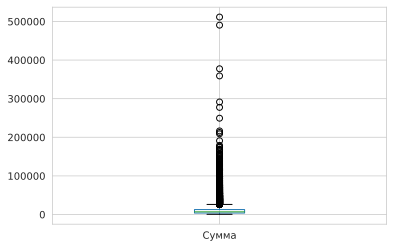

In [13]:
boxplot = df.boxplot('Сумма')
plt.show()

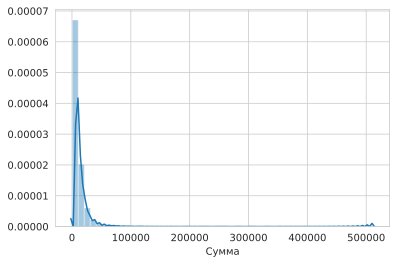

In [14]:
#График распределения плотности по сумме
sns.distplot(df['Сумма'].astype(int))

In [15]:
#График линейной зависимости даты от суммы продаж или количество проданных товаров
# преобразуем к объекту
#df["Дата"] = pd.to_datetime(df["Дата"], format='%d.%m.%Y %H:%M')
#df

df['Дата'] = pd.to_datetime(df['Дата'])
df['День'] = df['Дата'].dt.date
df['Месяц'] = df['Дата'].dt.month
df.head()


,Дата,Клиент,Товар,Сумма,День,Месяц
Транзакция,,,,,,
954,2020-03-05 21:43:00,1,2874,8150.0,2020-03-05,3
13796,2020-11-20 20:46:00,1,3586,3930.0,2020-11-20,11
14431,2020-08-12 16:28:00,1,4942,2860.0,2020-08-12,8
951,2020-03-05 21:15:00,2,2812,4895.0,2020-03-05,3
3352,2020-05-20 16:46:00,2,5025,840.0,2020-05-20,5


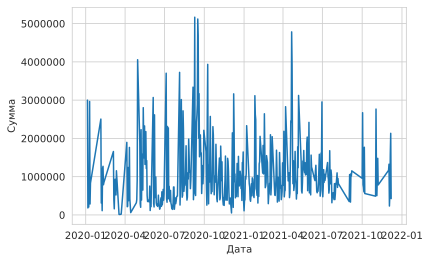

In [16]:
df["День"] = df["Дата"].dt.date
df_date = df[['Сумма', 'День']].groupby('День').sum().sort_values('День', ascending=True).reset_index()

plt.plot(df_date['День'], df_date['Сумма'])
plt.xlabel('Дата')
plt.ylabel('Сумма')
plt.show()

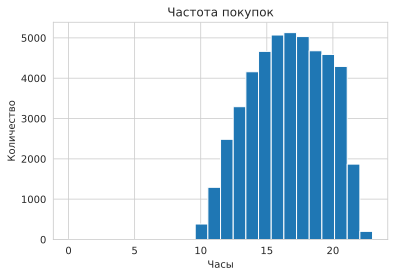

In [17]:
# Стобчатая диаграмма частоты покупок от количество часов
plt.hist(df["Дата"].dt.hour.values, bins=24)
plt.xlabel('Часы')
plt.ylabel('Количество')
plt.title('Частота покупок')
plt.show()

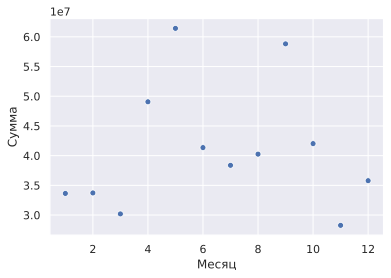

In [18]:
# по месяцам
df["Месяц"] = df["Дата"].dt.month
mon = df[['Сумма', 'Месяц']].groupby('Месяц').sum().reset_index()
sns.set()
sns.scatterplot('Месяц', 'Сумма', data=mon)
plt.xlabel('Месяц')
plt.ylabel('Сумма')
plt.show()

In [19]:
df

,Дата,Клиент,Товар,Сумма,День,Месяц
Транзакция,,,,,,
954,2020-03-05 21:43:00,1,2874,8150.0,2020-03-05,3
13796,2020-11-20 20:46:00,1,3586,3930.0,2020-11-20,11
14431,2020-08-12 16:28:00,1,4942,2860.0,2020-08-12,8
951,2020-03-05 21:15:00,2,2812,4895.0,2020-03-05,3
3352,2020-05-20 16:46:00,2,5025,840.0,2020-05-20,5
...,...,...,...,...,...,...
25398,2021-06-07 15:00:00,11049,1211,20500.0,2021-06-07,6
25399,2021-06-07 15:13:00,11049,3034,21950.0,2021-06-07,6
25412,2021-06-07 15:02:00,11050,443,1490.0,2021-06-07,6


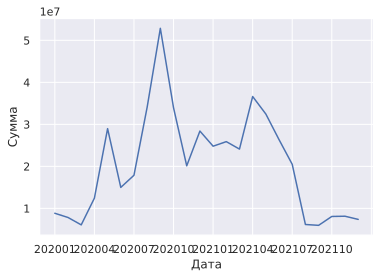

In [20]:
# Динамика покупок за весь период

df['Число'] = df['День'].apply(lambda x: "".join([str(x.year), ("0"+str(x.month))[-2:]]))
months = sorted(list(set(df['Число'].values)))
months_sum = []

for month in months:
    months_sum.append(df[df['Число'] == month]['Сумма'].values.sum())

fig, ax = plt.subplots()
ax.xaxis.set_major_locator(ticker.MultipleLocator(3))
plt.plot(months, months_sum)
plt.rcParams["figure.figsize"] = (10, 3)
plt.xlabel('Дата')
plt.ylabel('Сумма')
plt.show()

In [21]:
#Популярные товары
df.Товар.value_counts()

4944    725
4911    580
3487    435
434     430
2635    425
       ... 
1588      1
2248      1
201       1
3509      1
2047      1
Name: Товар, Length: 5293, dtype: int64

In [22]:
#### Показать товары  максимальной выручкой за все время 
df.groupby('Товар')['Сумма'].sum() 

Товар
1        1495.00
2       14150.00
3        1200.00
4        2200.00
5        4580.89
          ...   
5519     5495.00
5520    19450.00
5521    14950.00
5522    24700.00
5523    48295.00
Name: Сумма, Length: 5293, dtype: float64

In [23]:
#Создать дополнительные признаки 

# По графику видно, что время тоже влияет
df['Час'] = df["Дата"].dt.hour.values

In [24]:
df = df[['Дата', 'Клиент', 'Товар', 'Сумма', 'Месяц', 'Час']]

In [25]:
df

,Дата,Клиент,Товар,Сумма,Месяц,Час
Транзакция,,,,,,
954,2020-03-05 21:43:00,1,2874,8150.0,3,21
13796,2020-11-20 20:46:00,1,3586,3930.0,11,20
14431,2020-08-12 16:28:00,1,4942,2860.0,8,16
951,2020-03-05 21:15:00,2,2812,4895.0,3,21
3352,2020-05-20 16:46:00,2,5025,840.0,5,16
...,...,...,...,...,...,...
25398,2021-06-07 15:00:00,11049,1211,20500.0,6,15
25399,2021-06-07 15:13:00,11049,3034,21950.0,6,15
25412,2021-06-07 15:02:00,11050,443,1490.0,6,15


In [26]:
#объем продаж 
Total = df['Сумма'].sum()
Total

492923576.91

In [27]:
df.quantile([0,0.25,0.5,0.75,1])

,Клиент,Товар,Сумма,Месяц,Час
0.00,1.0,1.0,504.0,1.0,0.0
0.25,2000.0,1822.0,3810.0,4.0,15.0
0.50,3922.0,3146.0,6910.0,6.0,17.0
0.75,6903.0,4803.0,12750.0,9.0,19.0
1.00,11050.0,5523.0,511500.0,12.0,23.0


In [28]:
q = df['Сумма'].quantile(0.99)
q

59350.0

**Корреляция**

In [29]:
# Вывести график sns.heatmap
corr = df.corr()
corr

# Корреляция у нас не очень большая, поэтому сохраняем всю

# corr_greater_than_50 = corr[corr >= .5]
# print(corr_greater_than_50)
# sns.heatmap()

,Клиент,Товар,Сумма,Месяц,Час
Клиент,1.000000,0.030204,0.068582,-0.083102,-0.013873
Товар,0.030204,1.000000,0.091975,-0.010450,0.011173
Сумма,0.068582,0.091975,1.000000,0.011827,0.019960
Месяц,-0.083102,-0.010450,0.011827,1.000000,0.006756
Час,-0.013873,0.011173,0.019960,0.006756,1.000000


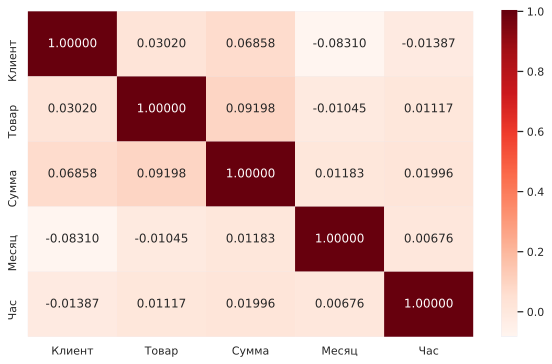

In [30]:
sns.set(rc={'figure.figsize':(10, 6)}) # for label size

ax = sns.heatmap(corr, cmap="Reds", annot=True, fmt='.5f') #notation: "annot" not "annote"
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

plt.show()

# Вообще, достаточно найти корреляцию между суммой и месяцем/часом, тк всё остальное просто айдишники

In [31]:
# from scipy.stats import spearmanr
# from scipy.stats.stats import pearsonr
# # Ваш код расчитать коэф корреляции
# a = df['Клиент']
# b = df['Сумма']
# rho_coef, rho_p = spearmanr(a, b)
# r_coef, r_p = pearsonr(a, b)
# print('Pearson r %0.3f | Spearman rho %0.3f' 
#       % (r_coef, rho_coef))

# Здесь нет смысла считать корреляцию между индексом клиента и товаром, тк индекс - просто рандомное число

In [32]:
# Коэффициенты Спирмана
from scipy import stats
print(stats.spearmanr(df[['Сумма', 'Месяц', 'Час']]).correlation)

[[1.         0.00134334 0.03240907]
 [0.00134334 1.         0.00575727]
 [0.03240907 0.00575727 1.        ]]


In [33]:
# Коэффициенты Пирсона
print(stats.pearsonr(df['Сумма'].values, df['Сумма'].values)[0])
print(stats.pearsonr(df['Сумма'].values, df['Месяц'].values)[0])
print(stats.pearsonr(df['Сумма'].values, df['Час'].values)[0])

1.0
0.011826814604107973
0.019959762828067794


### 5.	Выполнить проверку гипотез о данных

5.1 Зависит ли частота покупок от месяца?

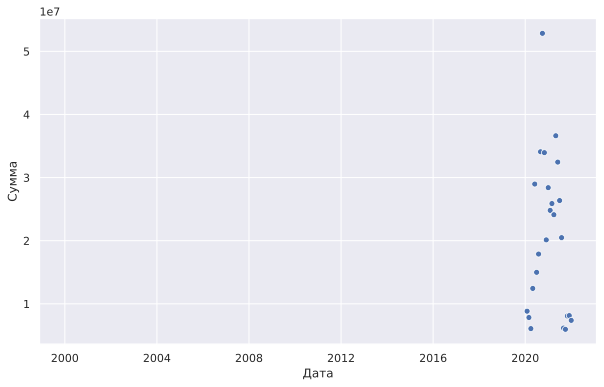

In [34]:
time = df[['Дата', 'Сумма']]
time['Дата'] = pd.to_datetime(time['Дата'])
time.set_index('Дата', inplace=True)
time = time.resample('M').sum().sort_values('Дата', ascending=True)

sns.set()
sns.scatterplot(time.index, 'Сумма', data=time)

 5.2 Больше лучших клиентов, чем потерянных клиентов?
 
 Т.е. выяснить больше ли клиентов, которые покупали совсем недавно, чаще всего и тратят больше всего, 
 чем клиентов, у которых последняя покупка была давно, и покупали мало и тратили мало.

In [36]:
df_ = df.reset_index()
df_['Дата'] = pd.to_datetime(df_['Дата'])
df_["День"] = df_["Дата"].dt.date
df_['Количество'] = 1

Now = df_['День'].max()
df_ = df_.groupby(['Транзакция', 'Клиент', 'День'])['Количество', 'Сумма'].sum().reset_index().drop_duplicates().groupby('Клиент').agg({'День': lambda x: (Now - x.max()).days,'Транзакция': lambda x: len(x), 'Сумма': lambda x: x.sum()})
print(df_)   

        День  Транзакция     Сумма
Клиент                            
1        382           3   14940.0
2        205           4   88540.0
3        642           1    7100.0
4         65          26  351196.5
5        581           1    3035.0
...      ...         ...       ...
11046    142           2   54580.0
11047    122           4   39575.0
11048    183           1   17100.0
11049    183           2   42450.0
11050    183           1   16430.0

[10989 rows x 3 columns]


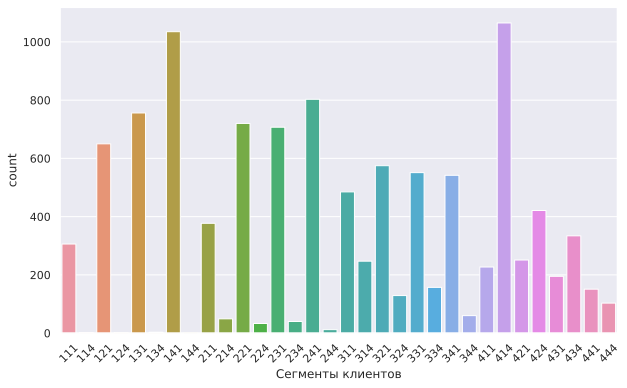

In [37]:
bin_labels = ['1', '2', '3', '4']
bin_labels2 = ['1', '4']
df_['quantile_Затраты'] = pd.qcut(df_['Сумма'], q=[0, 0.25, 0.5, 0.75, 1], labels=bin_labels)
df_['quantile_Давность'] = pd.qcut(df_['День'], q=[0, 0.25, 0.5, 0.75, 1], labels=bin_labels)
df_['quantile_Частота'] = pd.qcut(df_['Транзакция'], q=[0.25, 0.75, 1], labels=bin_labels2)
df_['Сегменты клиентов'] = df_['quantile_Затраты'].astype(str) + df_['quantile_Давность'].astype(str)+df_['quantile_Частота'].astype(str)
sns.set()
ax = sns.countplot(x='Сегменты клиентов', data=df_)
ax = ax.set_xticklabels(ax.get_xticklabels(), rotation=45)